In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [2]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [3]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,1611.000000,1611.000000,1.611000e+03,1611.000000,1.611000e+03,1611.000000,1.611000e+03,1.611000e+03
mean,1888.329206,-0.990426,4.625512e-07,-0.000165,2.106916e-07,0.000007,-2.293804e-07,8.502873e-13
std,1087.191417,0.001020,3.211465e-03,0.000709,2.137882e-03,0.006605,1.462589e-03,1.169117e-12
min,7.011123,-0.991665,-4.521058e-03,-0.001121,-3.245545e-03,-0.009033,-2.051272e-03,-1.184596e-12
25%,947.670150,-0.991459,-3.225939e-03,-0.000867,-1.972796e-03,-0.006503,-1.474532e-03,-6.626360e-14
50%,1888.329000,-0.990594,-1.989669e-06,-0.000213,-1.827882e-06,-0.000346,7.881993e-07,5.195383e-13
75%,2828.988500,-0.989404,3.223399e-03,0.000537,1.982946e-03,0.006466,1.471320e-03,1.714052e-12
max,3769.647000,-0.988843,4.521061e-03,0.000898,3.245547e-03,0.009931,2.051271e-03,3.628293e-12


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

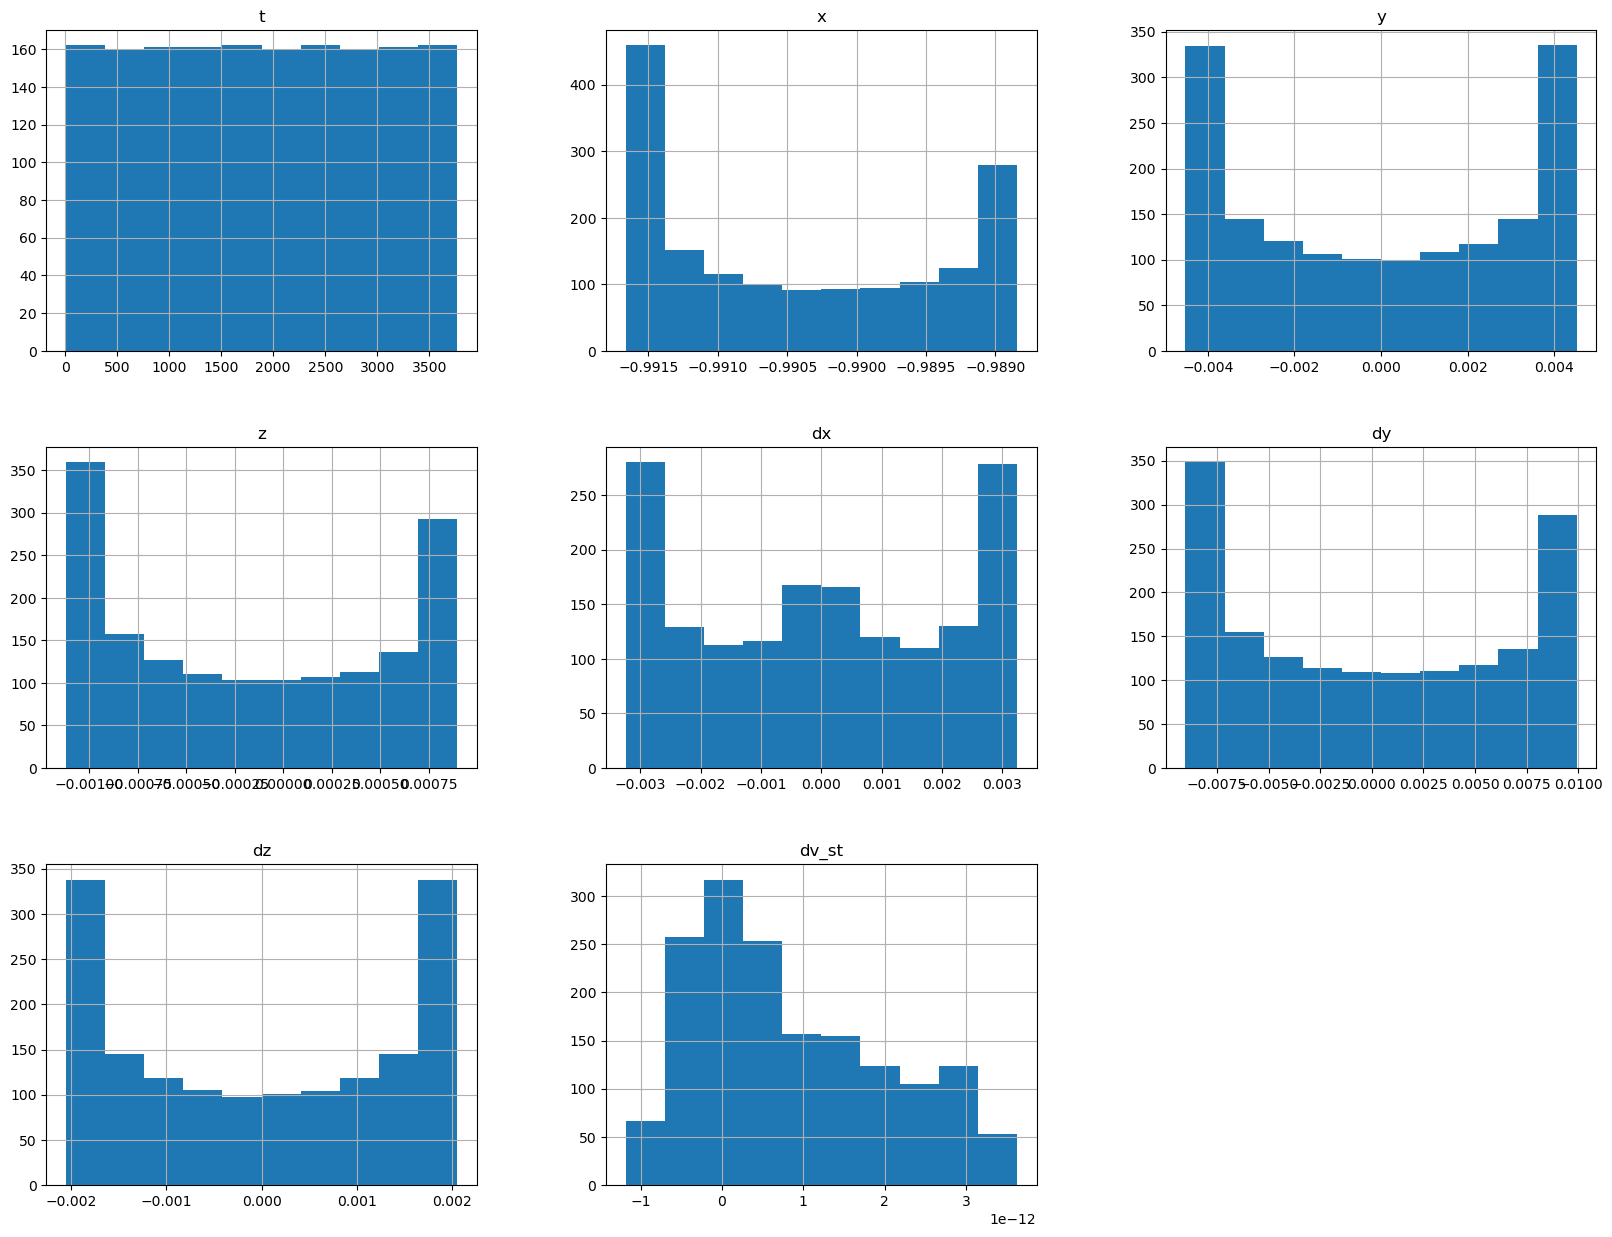

In [4]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Visualizing Data

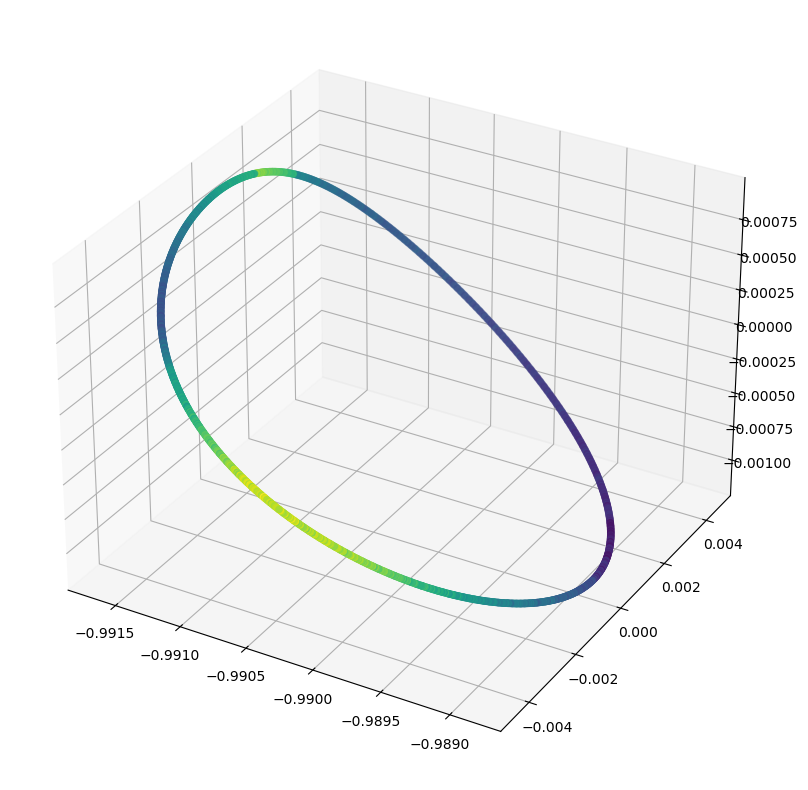

In [5]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [6]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
dz       0.589263
dy       0.293014
z        0.288406
x       -0.318058
y       -0.635301
dx      -0.742758
Name: dv_st, dtype: float64

array([[<Axes: xlabel='x', ylabel='x'>, <Axes: xlabel='dx', ylabel='x'>,
        <Axes: xlabel='dv_st', ylabel='x'>],
       [<Axes: xlabel='x', ylabel='dx'>,
        <Axes: xlabel='dx', ylabel='dx'>,
        <Axes: xlabel='dv_st', ylabel='dx'>],
       [<Axes: xlabel='x', ylabel='dv_st'>,
        <Axes: xlabel='dx', ylabel='dv_st'>,
        <Axes: xlabel='dv_st', ylabel='dv_st'>]], dtype=object)

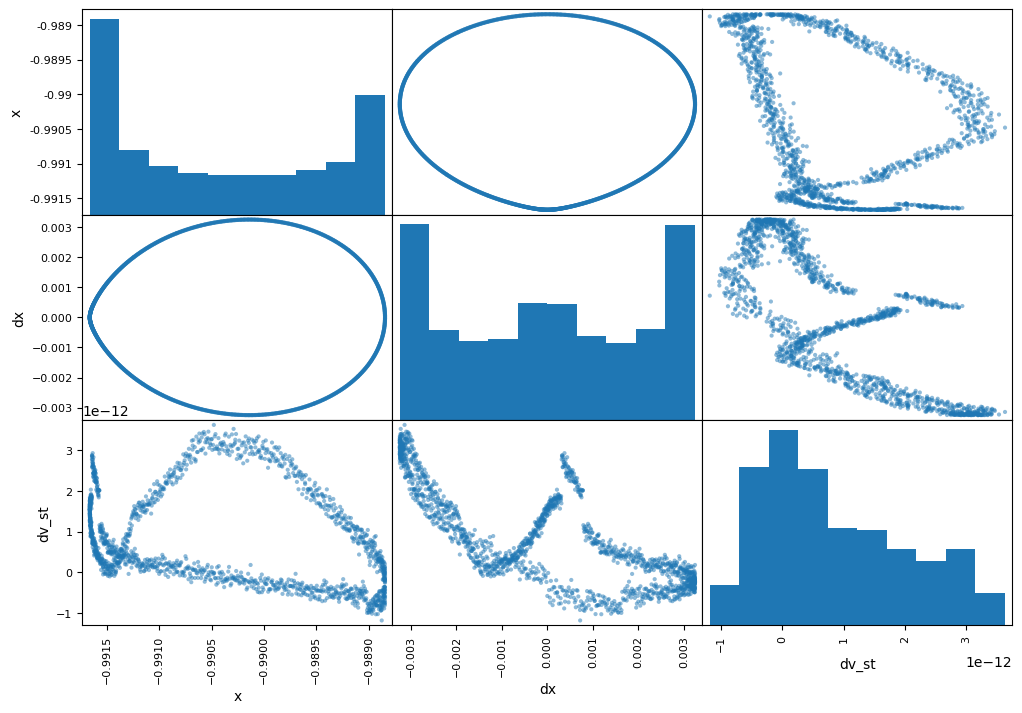

In [7]:
#attributes = ["angle", "x", "dx", "dv_st"]
attributes = ["x", "dx", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

# Prepare the Data for Machine Learning Algorithms

## Create a Train/Test Set

In [8]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz
0,-0.991632,0.001648,0.000819,0.000412,0.009151,-0.000904
1,-0.991159,-0.004179,0.000217,-0.002208,0.003548,0.002003
2,-0.989104,-0.002210,-0.001006,-0.001970,-0.007873,0.000886
3,-0.989641,0.003628,-0.000752,0.003004,-0.005385,-0.001497
4,-0.991507,0.003047,0.000603,0.001104,0.007085,-0.001584


In [9]:
## Create Train/Test/Validation Sets

In [10]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(966, 6)
(323, 6)
(322, 6)


,x,y,z,dx,dy,dz
407,-0.991659,-0.000724,0.000883,-0.000154,0.009783,0.000404
214,-0.988896,-0.001018,-0.001098,-0.000930,-0.008799,0.000404
352,-0.991649,-0.001205,0.000857,-0.000275,0.009518,0.000667
988,-0.991165,-0.004169,0.000223,-0.002194,0.003597,0.002000
315,-0.990044,-0.004192,-0.000542,-0.003237,-0.003386,0.001777


In [11]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.00194904, 0.41993632, 0.99264234, 0.47624072, 0.99218384,
        0.59842451],
       [0.98114745, 0.38736216, 0.01142042, 0.356712  , 0.0123467 ,
        0.59857234],
       [0.00570538, 0.36678798, 0.97942641, 0.45757962, 0.97822817,
        0.66259897],
       [0.17704384, 0.03889512, 0.66534655, 0.1619418 , 0.66598416,
        0.98757959],
       [0.57432935, 0.03637502, 0.28689217, 0.00129501, 0.2977832 ,
        0.93315796]])

In [12]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_valid_scaled = scaler.transform(y_valid)
y_test_scaled = scaler.transform(y_test)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [14]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(X_train_scaled)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.05358251006402272

Clearly not a great score: the SD(dv_st) value is 8.e-7, so a typical prediction error of 6.6.e-7 is not great.

In [15]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = tree_reg.predict(X_train_scaled)
tree_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

NOW THIS IS MUCH BETTER!!

In [16]:
#Let's try it out on 5 instances from the test set
some_data = X_test_scaled[10:20]
some_labels = y_test_scaled[10:20]
print("Predictions:", list(tree_reg.predict(some_data)))
print("Labels:", list(some_labels))

Predictions: [0.19480171902194732, 0.4124096582848672, 0.8351096399353625, 0.6152354381771861, 0.2903548250538044, 0.8281881278046298, 0.892666139200615, 0.14306418314778852, 0.2797582381493878, 0.11421448663807479]
Labels: [array([0.23982193]), array([0.45640896]), array([0.84966735]), array([0.64179837]), array([0.2806566]), array([0.89891396]), array([0.85979422]), array([0.11770585]), array([0.27614437]), array([0.183368])]


In [17]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = forest_reg.predict(X_train_scaled)
forest_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.01412546220899347

## Polynomial Regression

In [18]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(X_train_scaled)
#print(X_train_scaled.head())
#print(maneuvers_pred_poly[0])

In [19]:
lin_reg = LinearRegression()
lin_reg.fit(maneuvers_pred_poly, y_train_scaled)
maneuvers_predictions = lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.038937711204536006

## SVM Regression

In [20]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(X_train_scaled, y_train_scaled)
maneuvers_predictions = svm_poly_reg.predict(X_train_scaled)
svm_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.05762502016726835

## Cross-validation

Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [21]:
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, X_train_scaled, y_train_scaled,
scoring="neg_root_mean_squared_error", cv=5)
tree_rmse_scores = -scores

In [22]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [0.04185092 0.04296723 0.05004681 0.0438675  0.04558578]
Mean: 0.04486364777608669
Standard deviation: 0.0028653764995981218
